In [4]:
from __future__ import print_function, division

from pitch_perfect.thinkdsp import thinkdsp, thinkplot

import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10   # Time and Hz, i.e. labels
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 15  # Time(x) tick values
plt.rcParams['ytick.labelsize'] = 15  # Hz(y) tick values
plt.rcParams['legend.fontsize'] = 17
plt.rcParams['figure.titlesize'] = 10
plt.rcParams['axes.titlesize'] = 14   # Title font

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

%matplotlib inline
PI2 = np.pi * 2

import soundcard as sc
import IPython.display as ipd

from pitch_perfect.data.constants import *

# get a list of all speakers:
speakers = sc.all_speakers()
# get the current default speaker on your system:
default_speaker = sc.default_speaker()
# get a list of all microphones:
mics = sc.all_microphones()
# get the current default microphone on your system:
default_mic = sc.default_microphone()

from pitch_perfect import make_spectrum
from pitch_perfect import PATHS

## Test autocorrelation on piano

In [5]:
def get_piano_audio():
    waves = {}
    for i in range(8):
        waves[f'c{i}'] = thinkdsp.read_wave(PATHS.data / f'piano/c{i}.wav')
        waves[f'd{i}'] = thinkdsp.read_wave(PATHS.data / f'piano/d{i}.wav')
    return waves

In [6]:
piano_waves = get_piano_audio()

In [7]:
piano_waves['c0'].make_audio()

## Step 2. Difference function

$$d _ { t } ( \tau ) = \sum _ { j = 1 } ^ { W } \left( x _ { j } - x _ { j + \tau } \right) ^ { 2 }$$

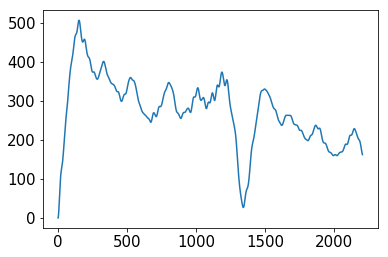

In [73]:
def difference(ys):
    N = len(ys)    
    return np.array([np.sum((ys[lag:] - ys[:N-lag]) ** 2) for lag in range(N//2)])
        
plt.plot(difference(piano_waves['c0'].ys[44100:44100+4410]))

## Step 3. Cumulative mean normalized diff. function

$$ d _ { t } ^ { \prime } ( \tau ) = \left\{ \begin{array} { l } { 1 , \quad \text { if } \tau = 0 } \\ { d _ { t } ( \tau ) / \left[ ( 1 / \tau ) \sum _ { j = 1 } ^ { \tau } d _ { t } ( j ) \right] \text { otherwise. } } \end{array} \right. $$

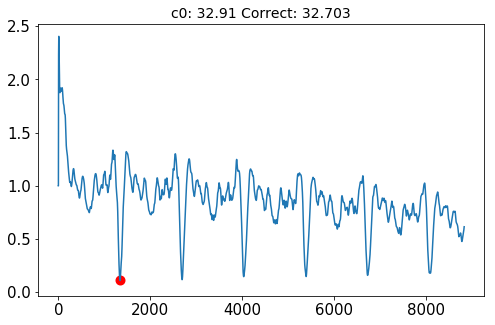

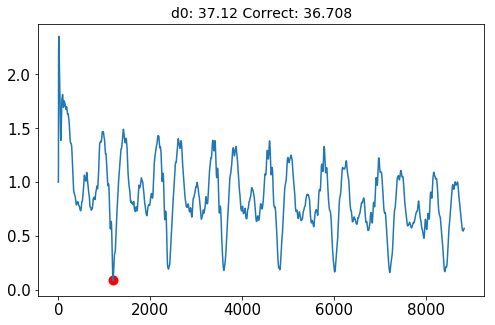

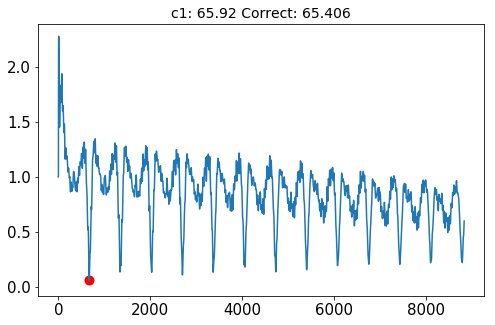

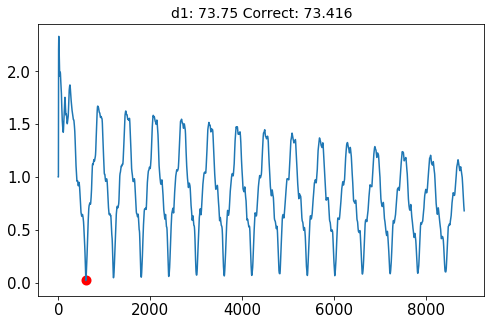

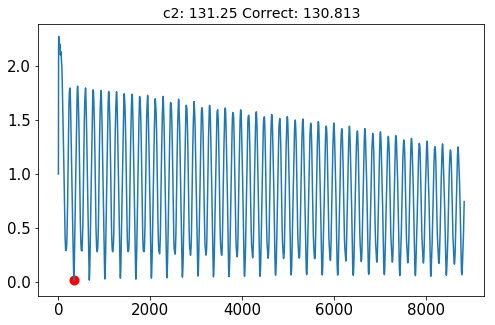

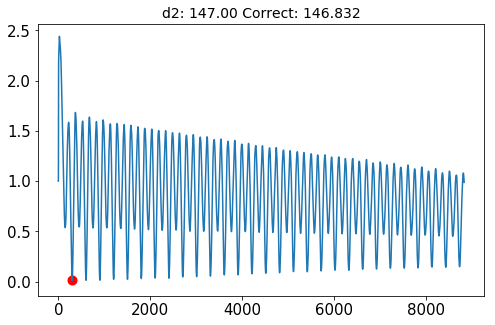

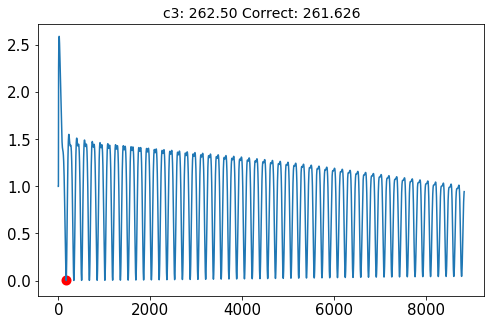

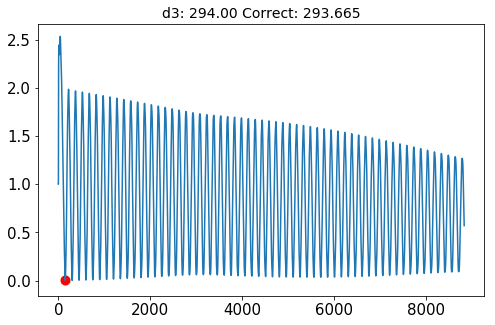

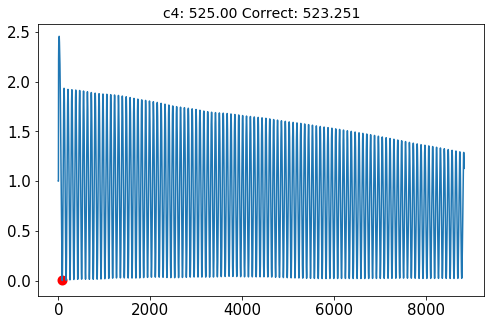

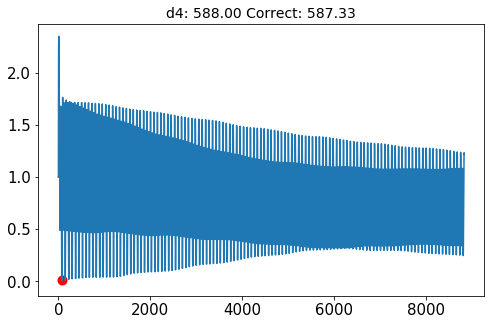

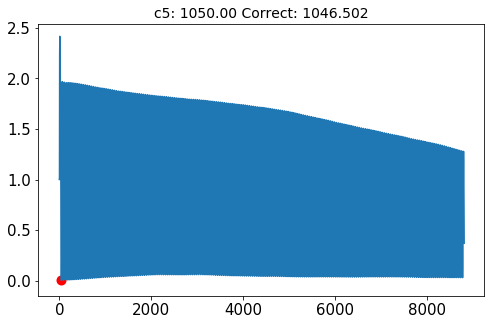

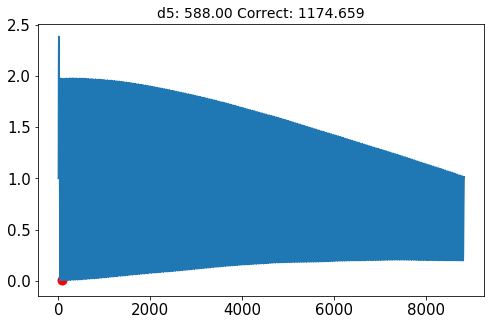

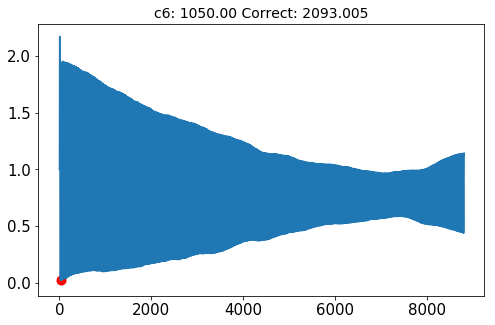

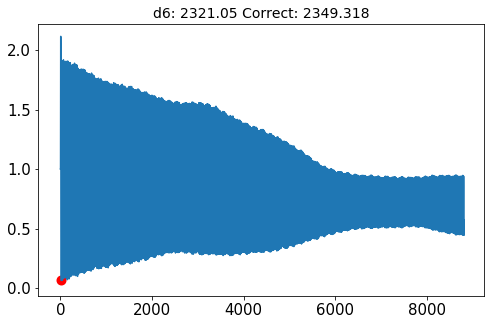

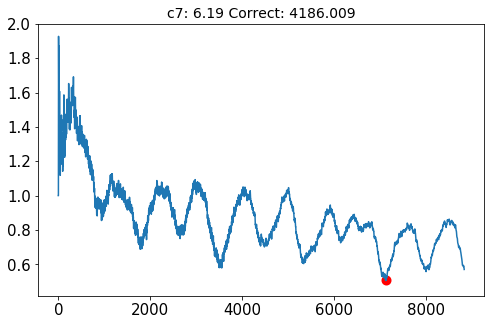

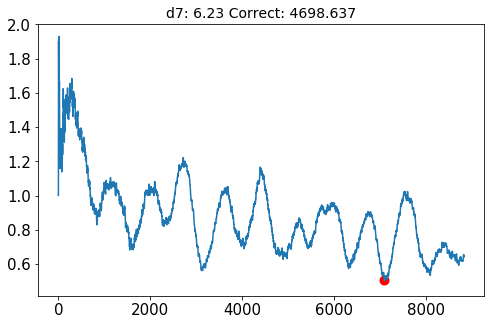

In [92]:
def cumulative_mean_normalized(diffs):
    cmn = np.zeros(diffs.shape)
    cmn[0] = 1
    for lag in range(1, len(diffs)) :
        cmn[lag] = diffs[lag] / (
           np.sum(diffs[1:lag+1]) / lag
        )  
    return cmn


for key in piano_waves.keys():
    diffs = difference(piano_waves[key].ys[44100:44100+4410*4])
    cmn = cumulative_mean_normalized(diffs)
    # print(cmn.argmin())

    plt.figure(figsize=(8, 5))
    plt.plot(cmn)
    plt.scatter([cmn.argmin()], [cmn[cmn.argmin()]], c='r', lw=4)
    plt.title(f'{key}: {44100/cmn.argmin():.2f} Correct: {KEY_FREQUENCY_MAP[key]}')

1340

## Step 4: Absolute threshold

$$ 1 / ( 4 W ) \sum _ { j = t + 1 } ^ { t + W } \left( x _ { j } + x _ { j + T } \right) ^ { 2 } + 1 / ( 4 W ) \times \sum _ { j = t + 1 } ^ { t + W } \left( x _ { j } - x _ { j + T } \right) ^ { 2 } $$

### Parameters
- W: window size
- T: period


In [67]:
def absolute_threshold(ys, period):
    """
    Args:
        ys: signal
        period (int):
    """
    w = len(ys)
    
    left = np.sum(np.array(
        [(ys[i] + ys[i+period]) ** 2 for i in range(1, w)]
    )) / (4*w)
    
    right = np.sum(np.array(
        [(ys[i] - ys[i+period]) ** 2 for i in range(1, w)]
    )) / (4*w)
    
    return left + right


absolute_threshold(piano_waves['c0'].ys[:4410*4], 44100)

IndexError: index 44101 is out of bounds for axis 0 with size 17640

## Step 5: Parabolic interpolation

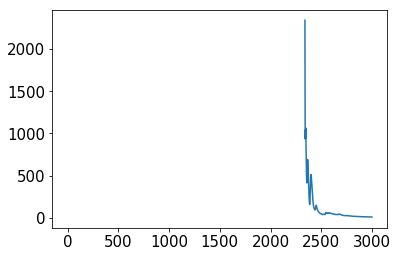

In [59]:
def dc(data):
    tau_max = 3000
    w_size = 6000
    r = np.zeros(tau_max)
    for i in range(tau_max):
        s = 0.0
        for j in range(w_size):
            s += (data[j] - data[j+i]) * (data[j] - data[j+i])
        r[i] = s
        
    d = np.zeros(tau_max)
    s = r[0]
    d[0] = 1
    for i in range(1,tau_max):
        s += r[i]
        d[i] = r[i] / ((1 / i) * s) 
        
    return d

plt.plot(dc(piano_waves['c0'].ys[:4410*4]))

In [47]:
1 / (cmn.argmin() / 44100)

32.86140089418778

65.82089552238806


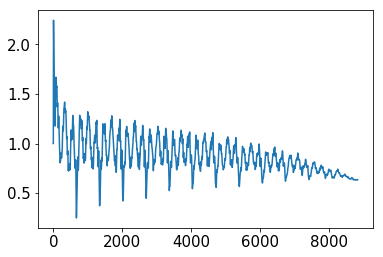

In [48]:
diffs = difference(piano_waves['c1'].ys[:4410*4])
cmn = cumulative_mean_normalized(diffs)
print(1 / (cmn.argmin() / 44100))
plt.plot(cmn)

2100.0


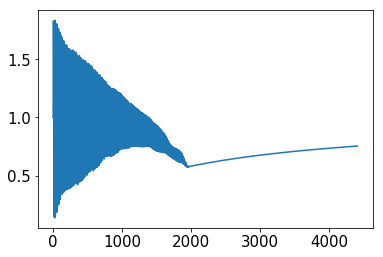

In [49]:
diffs = difference(piano_waves['c7'].ys[:4410*2])
cmn = cumulative_mean_normalized(diffs)
print(1 / (cmn.argmin() / 44100))
plt.plot(cmn)

2100.0


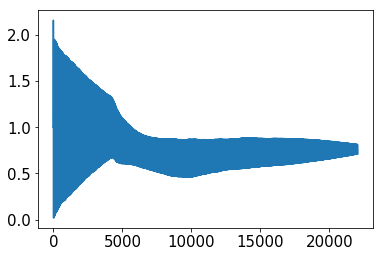

In [53]:
diffs = difference(piano_waves['c6'].ys[:4410*10])
cmn = cumulative_mean_normalized(diffs)
print(1 / (cmn.argmin() / 44100))
plt.plot(cmn)

In [37]:
np.sum(diffs[1:1+1]) / 1

8.864758324160487

In [38]:
diffs

array([   0.        ,    8.86475832,   34.88040425, ..., 1147.35535542,
       1147.03545049, 1146.8072081 ])

In [35]:
cmn

array([1.        , 1.        , 1.59470909, ..., 0.64857516, 0.64842017,
       0.648317  ])

No handles with labels found to put in legend.


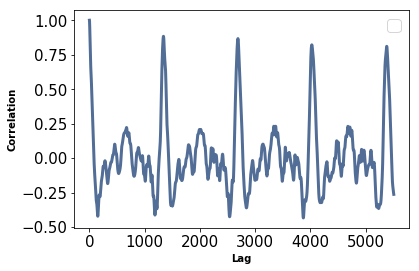

In [58]:
c0_corr = autocorrelate(piano_waves['c0'].ys[44100:44100+44100//4])

thinkplot.plot(c0_corr)
thinkplot.config(xlabel='Lag', ylabel='Correlation')#, ylim=[-1.05, 1.05])

In [60]:
c0_corr.argmin()

3874

In [59]:
c0_corr[np.array(c0_corr[low:high]).argmax() + 1000]

0.8833644113373929

In [25]:
low, high = 1000, 1500
lag = np.array(c0_corr[low:high]).argmax() + low
lag

1341

In [26]:
period = lag / 44100
period

0.030408163265306123

In [27]:
frequency = 1 / period
frequency

32.88590604026846

No handles with labels found to put in legend.


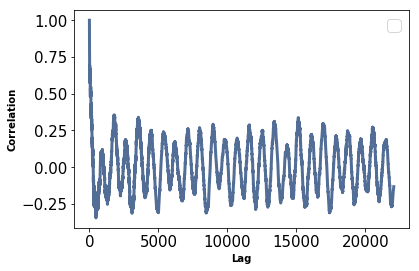

In [62]:
c7_corr = autocorrelate(piano_waves['c7'].ys[44100:44100+44100])

thinkplot.plot(c7_corr)
thinkplot.config(xlabel='Lag', ylabel='Correlation')#, ylim=[-1.05, 1.05])

No handles with labels found to put in legend.


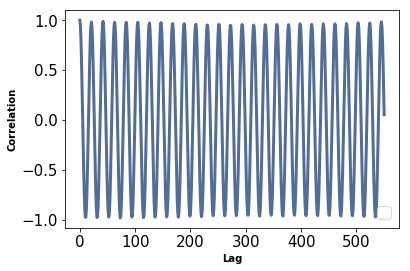

In [63]:
c6_corr = autocorrelate(piano_waves['c6'].ys[44100:44100+44100//40])

thinkplot.plot(c6_corr)
thinkplot.config(xlabel='Lag', ylabel='Correlation')#, ylim=[-1.05, 1.05])

In [72]:
c6_corr_copy = c6_corr[:]
c6_corr_copy = c6_corr_copy[c6_corr_copy > 0.9]
# np.argmax(aa>5)

In [5]:
def get_next_peak_range(ys):
    a = np.argmax(ys < 0.7)

    start = np.argmax(ys[a:] > 0.7) + a

    end = np.argmax(ys[start:] < 0.7) + start
    return start, end

def get_frequency(ys, start, end):
    lag = ys[start:end].argmax() + start
    period = lag / 44100
    return 1/period

In [106]:
c6_freq = get_frequency(c6_corr, *get_next_peak_range(c6_corr)); 
c6_freq, freq2key(c6_freq)

(2100.0, 'c7')

In [107]:
c5_freq = get_frequency(c5_corr, *get_next_peak_range(c5_corr)); 
c5_freq, freq2key(c5_freq)

(1050.0, 'c6')

In [6]:
for k, v in piano_waves.items():
    corrs = autocorrelate(v.ys[44100:44100+44100//4])
#     thinkplot.plot(corrs)
#     thinkplot.config(xlabel='Lag', ylabel='Correlation')#, ylim=[-1.05, 1.05])
    freq = get_frequency(corrs, *get_next_peak_range(corrs)); 
    pitch = freq2key(freq)
    print(f'Input: {k} --> {pitch}, {freq}')


Input: c0 --> c0, 32.88590604026846
Input: d0 --> d0, 37.12121212121212
Input: c1 --> c1, 65.91928251121077
Input: d1 --> d1, 73.74581939799332
Input: c2 --> c2, 131.25
Input: d2 --> d2, 147.0
Input: c3 --> c3, 262.5
Input: d3 --> d3, 294.0
Input: c4 --> c4, 525.0
Input: d4 --> d4, 588.0
Input: c5 --> c5, 1050.0
Input: d5 --> d5, 1191.8918918918919
Input: c6 --> c6, 2100.0
Input: d6 --> d6, 2321.0526315789475


ValueError: attempt to get argmax of an empty sequence

In [108]:
c1_freq = get_frequency(c1_corr, *get_next_peak_range(c1_corr)); 
c1_freq, freq2key(c1_freq)

(65.91928251121077, 'c2')

In [109]:
c0_freq = get_frequency(c0_corr, *get_next_peak_range(c0_corr)); 
c0_freq, freq2key(c0_freq)

(32.88590604026846, 'c1')

No handles with labels found to put in legend.


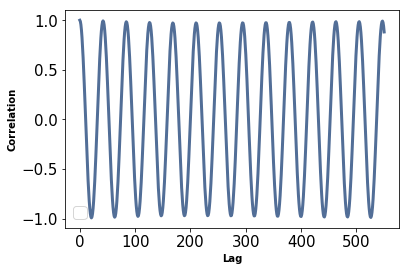

In [64]:
c5_corr = autocorrelate(piano_waves['c5'].ys[44100:44100+44100//40])

thinkplot.plot(c5_corr)
thinkplot.config(xlabel='Lag', ylabel='Correlation')#, ylim=[-1.05, 1.05])

No handles with labels found to put in legend.


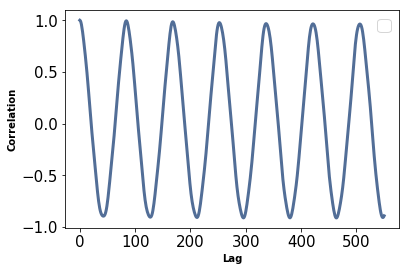

In [65]:
c4_corr = autocorrelate(piano_waves['c4'].ys[44100:44100+44100//40])

thinkplot.plot(c4_corr)
thinkplot.config(xlabel='Lag', ylabel='Correlation')#, ylim=[-1.05, 1.05])

No handles with labels found to put in legend.


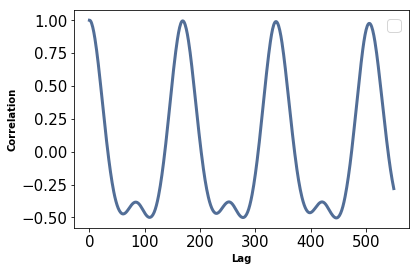

In [66]:
c3_corr = autocorrelate(piano_waves['c3'].ys[44100:44100+44100//40])

thinkplot.plot(c3_corr)
thinkplot.config(xlabel='Lag', ylabel='Correlation')#, ylim=[-1.05, 1.05])

No handles with labels found to put in legend.


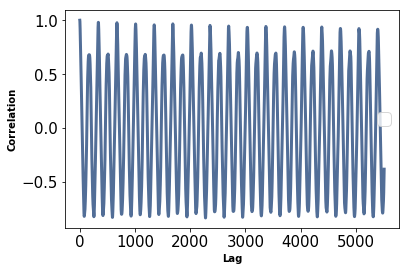

In [67]:
c2_corr = autocorrelate(piano_waves['c2'].ys[44100:44100+44100//4])

thinkplot.plot(c2_corr)
thinkplot.config(xlabel='Lag', ylabel='Correlation')#, ylim=[-1.05, 1.05])

No handles with labels found to put in legend.


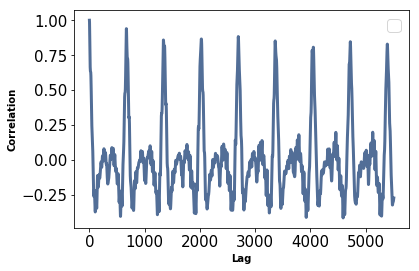

In [68]:
c1_corr = autocorrelate(piano_waves['c1'].ys[44100:44100+44100//4])

thinkplot.plot(c1_corr)
thinkplot.config(xlabel='Lag', ylabel='Correlation')#, ylim=[-1.05, 1.05])

In [61]:
c1_corr.argmin()

563

In [40]:
ipd.Audio(piano_waves['c4'].ys[44100:44100+44100//40], rate=44100)

In [25]:
low, high = 1000, 1500
lag = np.array(c0_corr[low:high]).argmax() + low
lag

1341

In [26]:
period = lag / 44100
period

0.030408163265306123

44100


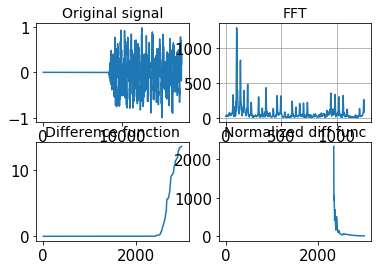

In [66]:
# Broken Reference

import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.io import wavfile
import numpy as np

fs = 44100
data = piano_waves['c0'].ys[:4410*4]

print(fs)

fig = plt.figure()
g1 = fig.add_subplot(221)
g1.set_title("Original signal")
g1.plot(data)


g2 = fig.add_subplot(222)
g2.set_title("FFT")
s = fft(data)
k = np.arange(len(data))
T = len(data)/fs
frqLabel = k/T

g2.plot(frqLabel[:500], abs(s[:500]))
g2.grid(b=True, which='both', color='0.65')



# autocorrelation thing
tau_max = 3000
w_size = 6000
r = np.zeros(tau_max)
for i in range(tau_max):
    s = 0.0
    for j in range(w_size):
        s += (data[j] - data[j+i]) * (data[j] - data[j+i])
    r[i] = s

g3 = fig.add_subplot(223)
g3.set_title("Difference function")
g3.plot(r)

# d` calculation
d = np.zeros(tau_max)
s = r[0]
d[0] = 1
for i in range(1,tau_max):
    s += r[i]
    d[i] = r[i] / ((1 / i) * s) 

g4 = fig.add_subplot(224)
g4.set_title("Normalized diff func")
g4.plot(d)

plt.show()

# find frequency. use 0.5 as threshold

for i in range(tau_max):
    if d[i] > 0.5:
        continue
    if d[i-1] > d[i] < d[i+1]:
        print(44100/i)
        break



In [64]:
# Broken reference
# https://github.com/kyungyunlee/yin-pitch-tracking-python/blob/master/yin_implementation.py

def divide_into_frames(y, frame_size, frame_stride, fs):
    frame_len = int(fs*frame_size) # number of samples in a single frame
    frame_step = int(fs*frame_stride) # number of overlapping samples
    total_frames = int(np.ceil(float(np.abs(len(y)-frame_len))/frame_step))
    print("Frame len %d, frame step %d, total frames %d"%(frame_len, frame_step, total_frames))
    padded_y = np.append(np.array(y), np.zeros(frame_len * total_frames - len(y)))
    framed_y = np.zeros((total_frames, frame_len))
    for i in range(total_frames):
        framed_y[i] = padded_y[i*frame_step : i*frame_step + frame_len] 
    print (framed_y.shape)
    return framed_y

def calculate_difference(signal) :
    half_len_signal = len(signal)//2
    tau = 0
    autocorr = np.zeros(half_len_signal)
    for tau in range(half_len_signal):
        for i in range(half_len_signal):
            diff = signal[i] - signal[i+tau]
            autocorr[tau] += diff**2
    
    return autocorr

def normalize_with_cumulative_mean(autocorr, halflen):
    new_autocorr = autocorr
    new_autocorr[0] = 1
    running_sum = 0.0
    for tau in range(1,halflen):
        running_sum += autocorr[tau]
        new_autocorr[tau] = autocorr[tau]/((1/tau)*running_sum)
    
    return new_autocorr

def absolute_threshold(new_autocorr, halflen, threshold):           
    temp = np.array(np.where(new_autocorr < threshold))
    if (temp.shape == (1,0)):
        tau = -1
    else : 
        tau = temp[:,0][0]
    return tau

def parabolic_interpolation(new_autocorr, tau, frame_len):
    if tau > 1 and tau < (frame_len//2-1):
        alpha = new_autocorr[tau-1]
        beta = new_autocorr[tau]
        gamma = new_autocorr[tau+1]
        improv = 0.5*(alpha - gamma)/(alpha - 2*beta + gamma)
    else :
        improv = 0
    
    new_tau = tau + improv
    return new_tau

def yin_pitchtracker(y, frame_size, frame_step, sr):
    framed_y = divide_into_frames(y, frame_size, frame_step, sr)
    pitches = []
    for i in range(len(framed_y)):
        autocorr = calculate_difference(framed_y[i])
        new_autocorr = normalize_with_cumulative_mean(autocorr, frame_len//2)
        tau = absolute_threshold(new_autocorr, frame_len//2, 0.16)
        new_tau = parabolic_interpolation(new_autocorr, tau, frame_len)
        if (new_tau == -1):
            pitch = 0
        else :
            pitch = sr/new_tau
        # print (pitch)
        pitches.append(pitch)
    return pitches

frame_len = int(0.03 * 44100)
pitches = yin_pitchtracker(piano_waves['c0'].ys, 0.03, 0.01, 44100)
print(pitches)

Frame len 1323, frame step 441, total frames 592
(592, 1323)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,